# Constellation Jypyter notebook

For easier testing of different parameters 
and possibly different reading patterns of message.

Read data17square.txt ("starmap") and draw a b/w image, similar to BatchDrake starmap = original_square.png. Included here so that it is easy to test different variations of width and height, 256 is not the only possible.

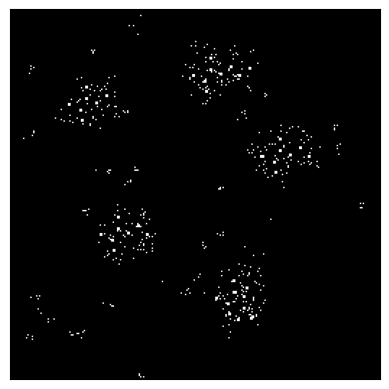

In [3]:
import numpy as np
import matplotlib.pyplot as plt

filename = "../artifacts/data17square.txt"
# Open the file in read mode
with open(filename, "r") as file:
    data = file.read()  # Read the content of the file

# Convert the string data to a list, where each character (0 or 1) is an element of the list
binary_array = [int(bit) for bit in data if bit == '0' or bit == '1']

width, height = 256, 256

# initialize array to zeroes
pixels = np.zeros((width, height))

y = 0
x = 0
for i in binary_array:
    
    if ((x<=(width-1)) and (y<=(height-1))):
        pixels[x][y] = i

    x=x+1

    if (x>(width-1)):
        x = 0
        y = y+1

# Remove x and y ticks
plt.xticks([])
plt.yticks([])

imagefilename="../visual/constellation_test.png"
plt.imshow(pixels,cmap='gray')
plt.savefig(imagefilename,dpi=300)

plt.show()


Identify constellations from image by comparing them to constellation_template.png. Draw an rectangle around identified features for verifying result.

Imagefile:../visual/constellation_test.png
Template read
5 valid constellations found
(929, 276)
(556, 362)
(1136, 518)
(652, 751)
(999, 944)


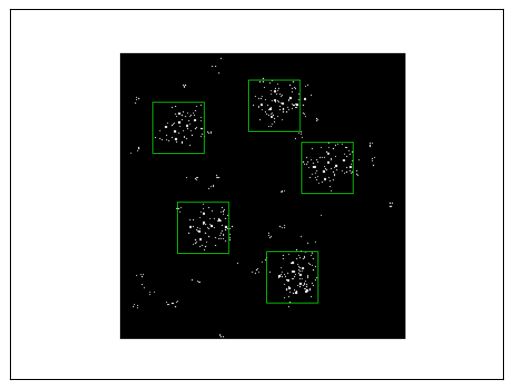

In [4]:
import cv2
import numpy as np
from skimage import transform as tf

# Load the image and the constellation template
image = cv2.imread(imagefilename, cv2.IMREAD_GRAYSCALE)
print(f"Imagefile:{imagefilename}")
template = cv2.imread('constellation_template.png', cv2.IMREAD_GRAYSCALE)
print("Template read")

# Create a color version of the image for drawing rectangles
color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Use template matching to find the constellations in the image
res = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
threshold = 0.45  # adjust this threshold as needed
loc = np.where(res >= threshold)
#print(f"loc: {loc}")
h, w = template.shape
roi_size = (200, 200)  # The size of the region of interest around each constellation

# Get the center points of the ROIs
#center_points = [(pt[0] + roi_size[0] / 2, pt[1] + roi_size[1] / 2) for pt in zip(*loc[::-1])]
center_points = [(int(pt[0] + h / 2), int(pt[1] + w / 2)) for pt in zip(*loc[::-1])]

# Remove center points that are too close to each other as algorithm gives false positives
min_distance = 10  # The minimum distance between center points
valid_center_points = []
for point in center_points:
    if all(np.sqrt((point[0] - valid_point[0])**2 + (point[1] - valid_point[1])**2) >= min_distance for valid_point in valid_center_points):
        valid_center_points.append(point)

print (f"{len(valid_center_points)} valid constellations found")
c = 1
for point in valid_center_points:
    topx = int(point[0] - roi_size[0] / 2)
    topy = int(point[1] - roi_size[1] / 2)
    bottomx = int(point[0] + roi_size[0] / 2)
    bottomy = int(point[1] + roi_size[1] / 2)

    # Draw a rectangle around the ROI on the color image copy
    top_left = (topx, topy)
    bottom_right = (bottomx, bottomy)
    cv2.rectangle(color_image, top_left, bottom_right, (0, 255, 0), 2)

    # if needed, center can be marked with circle
    #cv2.circle(color_image, (point[0],point[1]),10, (0, 255, 0), 2)
    print(f"{top_left}")

    # extract roi's to separate images
    # In Python, image coordinates are usually specified in (row, column) order
    # which corresponds to (y, x) in a Cartesian coordinate system
    roi = image[topy:bottomy, topx:bottomx]

    # Save the result
    cv2.imwrite('../visual/roi_constellation_{}.png'.format(c), roi)
    c = c + 1

# Convert the image from BGR to RGB
image_rgb = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)

# Display the image
plt.xticks([])
plt.yticks([])

plt.imshow(image_rgb)
plt.show()

Find and rotate constellations and stack them

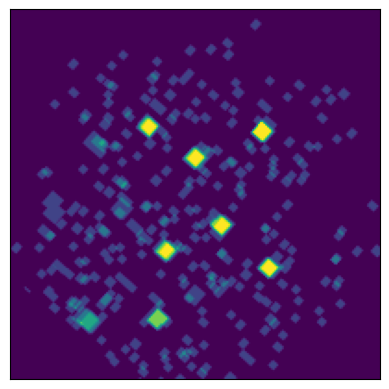

In [5]:
import cv2
import numpy as np

# Load the template
template = cv2.imread('constellation_template.png', 0)
h, w = template.shape
stacked_img = template
rotated_images = []
rotated_filenames = []
for c in range(1,6):
    # Load image
    image = cv2.imread('../visual/roi_constellation_{}.png'.format(c), 0)
    
    # Use template matching to find the pattern in the image
    res = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
    _, _, _, max_loc = cv2.minMaxLoc(res)

    # Calculate the center of the pattern
    center_pattern = (max_loc[0], max_loc[1])

    # Assume that when the image is correctly oriented,
    # the pattern should be at the same location as the center of the image
    center_image = (image.shape[1] // 2, image.shape[0] // 2)

    # Calculate the angle between the center of the image and the pattern
    dx, dy = center_pattern[0] - center_image[0], center_pattern[1] - center_image[1]
    angle = np.arctan2(dy, dx) * 180 / np.pi

    # Rotate the image to correct the orientation
    M = cv2.getRotationMatrix2D(center_image, angle, 1)
    rotated = cv2.warpAffine(image, M, image.shape[::-1])
#    cv2.imwrite("roi_constellation_rotated_{}".format(c), rotated)
    
    # Convert the image from BGR to RGB
    image_rgb = cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB)
    rotated_images.append(rotated)

    # Remove x and y ticks
    plt.xticks([])
    plt.yticks([])

    plt.imshow(image_rgb,cmap='gray')
    plt.savefig("../visual/roi_constellation_rotated_{}".format(c),dpi=300)
    rotated_filenames.append(f"../visual/roi_constellation_rotated_{c}.png")

# Average the images
average_img = np.mean(rotated_images, axis=0)

# Display the image
plt.xticks([])
plt.yticks([])

plt.imshow(average_img)
plt.savefig("../visual/roi_constellation_averaged",dpi=300)

plt.show()


Create an gif image from identified constellations to show possible "time-dimension" differences

/var/folders/mv/2vk3kv9x1ws04wfc6l_hr2pw0000gn/T/ipykernel_58839/1429510106.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


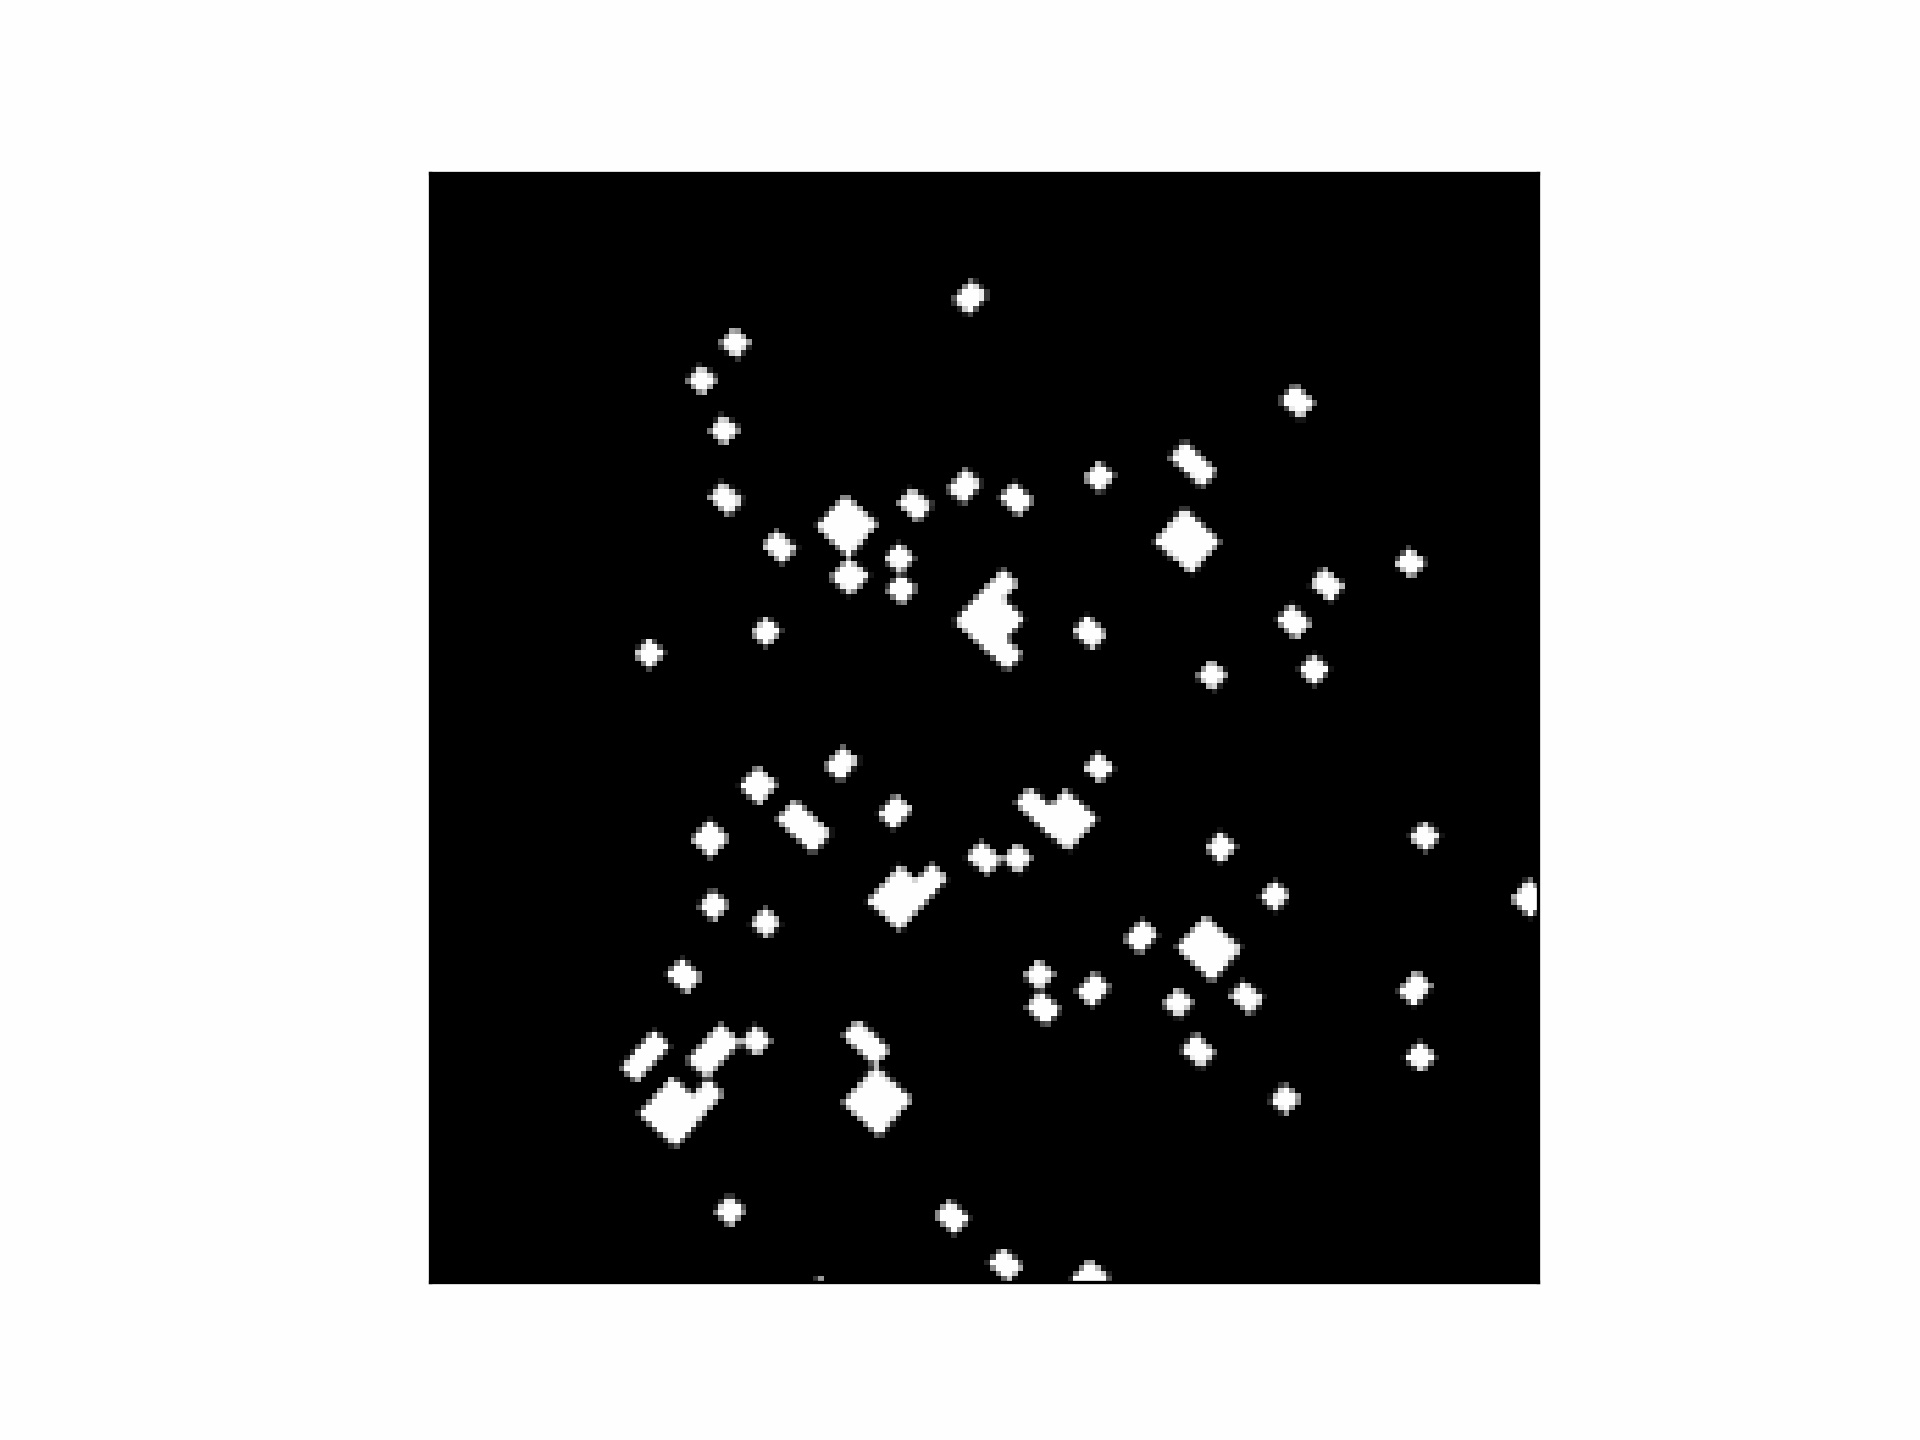

In [6]:
import imageio
from IPython.display import Image

# Read in images into a list
images = []
for filename in rotated_filenames:
    #print(f"Reading {filename}")
    images.append(imageio.imread(filename))

# Create GIF
imageio.mimsave('../visual/movie.gif', images, duration=200, loop=0)

Image(filename="../visual/movie.gif")